In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf

In [2]:
photoswitches = pd.read_csv('./photoswitches.csv')
smiles_list = photoswitches['SMILES'].to_list()

In [3]:
null_columns = photoswitches.columns[photoswitches.isnull().any()]
photoswitches[null_columns].isnull().sum() #two columns completely empty can be removed in raw dataset

rate of thermal isomerisation from Z-E in s-1             330
Solvent used for thermal isomerisation rates              353
Z PhotoStationaryState                                    329
E PhotoStationaryState                                    331
E isomer pi-pi* wavelength in nm                           13
Extinction                                                372
E isomer n-pi* wavelength in nm                           264
Extinction coefficient in M-1 cm-1                        379
Z isomer pi-pi* wavelength in nm                          312
Extinction.1                                              393
Z isomer n-pi* wavelength in nm                           282
Extinction coefficient in M-1 cm-1.1                      382
Wiberg index                                              390
E-Z irradiation wavelength in nm                          341
Z-E irradiation wavelength                                341
Irradiation solvent                                       184
PBE0 DFT

In [4]:
photoswitches.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dropped_data = photoswitches.drop(columns = ['a','BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm','BHLYP/6-31G* Z isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm'])
#raw_data = dropped_data.fillna(0)
dropped_data.to_csv ('rawdata_new.csv', index = False)

In [5]:
# split train & predict not in here!!!!
df_new = pd.read_csv('rawdata_new.csv')
df_test = df_new[df_new['E isomer pi-pi* wavelength in nm'].isnull()]
df_train = df_new[df_new['E isomer pi-pi* wavelength in nm'].notnull()]

In [6]:
#smiles_list = photoswitches['SMILES'].to_list()
morganfingerprints = pd.read_csv('./morgan_fingerprints.csv')

In [7]:
morganfingerprints_num = morganfingerprints.drop(morganfingerprints.columns[[0, 1]], axis = 1)
X = morganfingerprints_num
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
reduced_morgfingerprint = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_

array([0.03237783, 0.02517325])

In [8]:
df_reduced = pd.DataFrame(reduced_morgfingerprint)

In [9]:
df_joined = pd.merge(df_new, df_reduced, left_index=True, right_index=True)

In [10]:
df_test = df_joined[df_joined['E isomer pi-pi* wavelength in nm'].isnull()]
df_train = df_joined[df_joined['E isomer pi-pi* wavelength in nm'].notnull()]

In [11]:
X_hasvalue = df_train[[0, 1]]
y_hasvalue = df_train['E isomer pi-pi* wavelength in nm']

In [12]:
X_test = df_test[[0, 1]]
y_test= df_test['E isomer pi-pi* wavelength in nm']

In [13]:
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

34.70624256559766
[366.55716667 358.146      365.18316667 362.79       366.558
 358.07333333 358.21       365.62516667 365.47516667 367.61916667
 367.25516667 365.31716667 325.53      ]


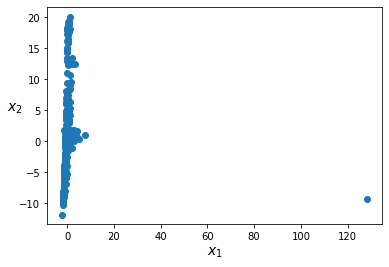

In [14]:
plt.scatter(reduced_morgfingerprint[:, 0], reduced_morgfingerprint[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [15]:
mordred = pd.read_csv('./mordred_descriptors.csv')
mordred_num = mordred.drop(mordred.columns[[0, 1]], axis = 1)
X_1 = mordred_num
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X_1)
pca = PCA(n_components=2)
reduced_mordred = pca.fit_transform(X1_scaled)
pca.explained_variance_ratio_

array([0.29043388, 0.11875416])

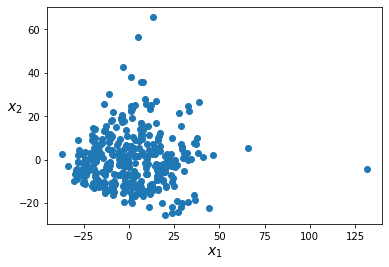

In [16]:
plt.scatter(reduced_mordred[:, 0], reduced_mordred[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [19]:
df_reduced_mordred = pd.DataFrame(reduced_mordred)
df_joined_mordred = pd.merge(df_new, df_reduced_mordred, left_index=True, right_index=True)
df_test_mordred = df_joined_mordred[df_joined_mordred['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_mordred = df_joined_mordred[df_joined_mordred['E isomer pi-pi* wavelength in nm'].notnull()]

In [20]:
X_hasvalue = df_train_mordred[[0, 1]]
y_hasvalue = df_train_mordred['E isomer pi-pi* wavelength in nm']
X_test = df_test_mordred[[0, 1]]
y_test= df_test_mordred['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

34.670485811467444
[368.048      379.53794286 379.462      392.418      457.982
 470.08       447.14       395.59       407.148      406.196
 452.358      407.516      360.242     ]
